In [1]:
using Plots, NLSolvers # define packages

In [2]:
# define constants
const V0 = 3. # the value has to be taken from the figure 1
const N = 400 # number of x points
const L_real = 0.05 # total length also non-dimensional point (l/re)
const c = 1.82;
const Vr = 3;
const dt = 0.05;   # adimensional time step 

In [34]:
# define functions

function sigmoid(V_row) # return a row of values from a row of V as imput
    return 1 ./ (1 .+ exp.(-c .* (V_row.-Vr)))
end
    
function G(V,nt,n,du,v) # here V should be the whole V matrix. G is a row of values
    Vrow = V[nt,:]
    NN = length(Vrow)
    timedelayed = nt * dt - (n * du / v)
    ntdelayed = Int64(round(timedelayed / dt))
    # display("printout of ntdelayed \n")
    # display(ntdelayed)
    if ntdelayed < 1
        return 2 .*sigmoid(V0*ones(1,NN))
    else
        G1 = zeros(1,NN)
        G2 = zeros(1,NN)
        for nx = 1:NN
            if nx - n < 1
                G1[nx] = sigmoid(V[ntdelayed,(N+1)-abs(nx-n)])
            else 
                G1[nx] = sigmoid(V[ntdelayed,nx-n])
            end
            if nx + n > N+1
                G2[nx] = sigmoid(V[ntdelayed,(nx+n)%(N+1)]) 
            else
                G2[nx] = sigmoid(V[ntdelayed,nx+n])
            end
        end
        return G1.+G2
    end
        
end

function integral_function(V,nt,eta,du,v)
    Vrow = V[nt,:]
    NN = length(Vrow)
    a = 1 ./((eta.^2).*du);
    # display(a)
    b = (1 ./eta).*(G(V,nt,0,du,v).+(G(V,nt,1,du,v).-G(V,nt,0,du,v))./(eta.*du));
    # display(b)
    K = (1/eta).*exp.(-eta.*L).*(G(V,nt,N+1,du,v).+(G(V,nt,N+1,du,v).-G(V,nt,N,du,v))./(eta.*du))
    # display(K)
    cc = zeros(N-1,NN)
    for nn = 0:N-2
        cc[nn+1,:] = exp.(-eta.*((nn+1).*du)).*(G(V,nt,nn+2,du,v).-2 .*G(V,nt,nn+1,du,v).+G(V,nt,nn,du,v));
    end 
    # display(cc)
    summ = sum(cc,dims=1)
    # display(summ)
    # display(a.*summ .+ b .- K)
    return a.*summ .+ b .- K
end

function J_function(V,nt,eta_1,eta_2,du,v,ae,ai)
    return 0.5 .*(ae.*integral_function(V,nt,eta_1,du,v) .- ai.*r.*integral_function(V,nt,eta_2,du,v))
end

function brainPatterns(V,eta_1,eta_2,du,v,ae,ai,phi,muP,N_t) 
    J=zeros(size(V))
    for nt = 1:N_t-1
        J[nt,:] = J_function(V,nt,eta_1,eta_2,du,v,ae,ai);
        V[nt+1,:] = V[nt,:] .+ dt.*phi[nt,:]
        phi[nt+1,:] = phi[nt,:] .+ dt.*(-2 .*phi[nt,:] .- V[nt,:] .+ J[nt,:] .+ muP)
    end
    return V,J,phi
end

brainPatterns (generic function with 2 methods)

In [37]:
# Turing Patterns
# parameters
ae = 6.;     # excitatory strenght
ai = 5.;     # inhibitory strenght
re = 0.0005;    # excitatory range (m)
ri = 0.001;     # inhibitory range (m)
r = re/ri;   # ratio
v_real = 0.08;# propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))
L = L_real / re
du = L/N;
x = 0:du:L;
muP0 = 2.5;   # external stimulus (constant)
T = 200
t = 0:dt:T/dt   # not sure

eta_1 = 1.0
eta_2 = r
N_t = length(t);
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
I = zeros(N_t,(N+1));
phi = zeros(N_t,(N+1));
J = zeros(N_t,(N+1));
V[1,:] = V0.*ones(1,N+1) .+ 0.05 .*randn(1,N+1);

V,J = brainPatterns(V,eta_1,eta_2,du,v,ae,ai,phi,muP0,11);

In [38]:
display(V)
display(J)

10×401 Matrix{Float64}:
 3.01693  2.97477  2.96756  2.91616  …  3.02613  2.88848  3.02307  2.94439
 3.01693  2.97477  2.96756  2.91616     3.02613  2.88848  3.02307  2.94439
 3.0169   2.97482  2.96763  2.91633     3.02607  2.88871  3.02302  2.9445
 3.01683  2.97492  2.96776  2.91666     3.02597  2.88914  3.02293  2.94472
 3.01674  2.97506  2.96794  2.91712     3.02582  2.88976  3.0228   2.94503
 3.01662  2.97524  2.96817  2.91772  …  3.02564  2.89055  3.02264  2.94542
 3.01648  2.97545  2.96844  2.91842     3.02542  2.89149  3.02245  2.94589
 3.01631  2.97569  2.96875  2.91922     3.02517  2.89255  3.02223  2.94642
 3.01613  2.97596  2.96909  2.92011     3.02489  2.89374  3.02198  2.94701
 3.01594  2.97625  2.96947  2.92108     3.02459  2.89502  3.02172  2.94765

10×401 Matrix{Float64}:
 0.503015  0.495508  0.494226  0.4851    …  0.48021   0.504107  0.490106
 0.503015  0.495508  0.494226  0.4851       0.48021   0.504107  0.490106
 0.503008  0.495518  0.494238  0.48513      0.480251  0.504099  0.490126
 0.502997  0.495535  0.49426   0.485188     0.480328  0.504083  0.490165
 0.50298   0.49556   0.494293  0.485271     0.480437  0.50406   0.49022
 0.502959  0.495592  0.494333  0.485376  …  0.480576  0.504031  0.49029
 0.502933  0.495629  0.494382  0.4855       0.480741  0.503996  0.490372
 0.502905  0.495672  0.494437  0.485642     0.480929  0.503957  0.490467
 0.502873  0.49572   0.494498  0.4858       0.481137  0.503914  0.490572
 0.502838  0.495772  0.494564  0.485971     0.481364  0.503866  0.490685

In [ ]:
?heatmap

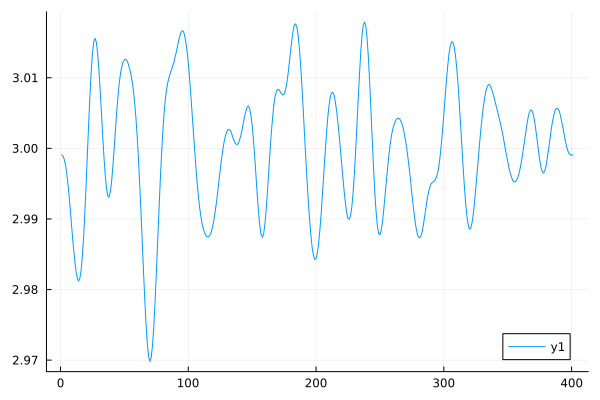

In [8]:
plot(V[Ntry,:])

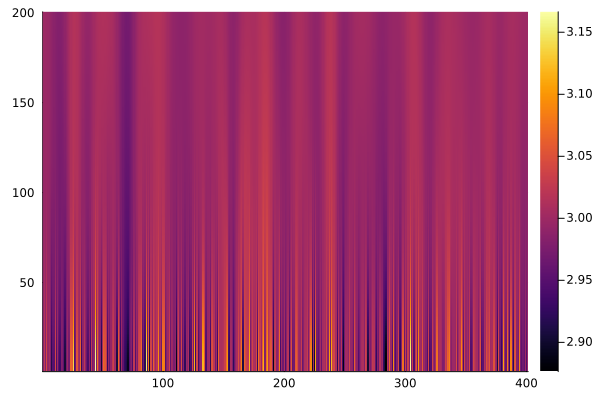

In [5]:
heatmap(V[1:Ntry,:])

In [21]:
# Waves - homogeneous stimulus

N_t = length(t);
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
I = zeros(N_t,(N+1));
phi = zeros(N_t,(N+1));
J = zeros(N_t,(N+1));
V[1,:] = V0.*ones(1,N+1) .+ 0.05 .*randn(1,N+1);
# v = 0.16;    # propagation velocity (m/s)
ae = 41;     # excitatory strenght
ai = 40;     # inhibitory strenght
re = 0.001;    # excitatory range (m)
ri = 0.00037;     # inhibitory range (m)
r = re/ri;   # ratio
eta_1 = 1.0
eta_2 = r
muP0 = 2.5;   # external stimulus (constant)
Ntry = 200


for nt = 1:Ntry
    for nx = 1:N+1
        J[nt,nx] = J_function(V,nx,nt,eta_1,eta_2,du,ae,ai);
    end
    V[nt+1,:] = V[nt,:] .+ dt.*phi[nt,:]
    phi[nt+1,:] = phi[nt,:] .+ dt.*(-2 .*phi[nt,:] .- V[nt,:] .+ J[nt,:] .+ muP0)
end


# the spatial dimension is wrong since the normalization has to be done with the new value of re

LoadError: BoundsError: attempt to access 2001×401 Matrix{Float64} at index [2002, 1:401]

In [22]:
display(V[1:Ntry,:])
display(J[1:Ntry,:])

2001×401 Matrix{Float64}:
 2.97221  3.00274  2.96791  3.01283  …  2.95298  3.02475  2.98592  3.0689
 2.97221  3.00274  2.96791  3.01283     2.95298  3.02475  2.98592  3.0689
 2.97248  3.00271  2.96822  3.01271     2.95342  3.02451  2.98605  3.06824
 2.97298  3.00266  2.9688   3.01247     2.95428  3.02406  2.98631  3.06699
 2.9737   3.00259  2.96963  3.01214     2.95549  3.02342  2.98667  3.06522
 2.9746   3.0025   2.97067  3.01173  …  2.95702  3.02262  2.98713  3.06298
 2.97566  3.0024   2.9719   3.01123     2.95882  3.02167  2.98767  3.06035
 2.97686  3.00228  2.97328  3.01068     2.96085  3.0206   2.98827  3.05737
 2.97818  3.00215  2.9748   3.01007     2.96307  3.01943  2.98894  3.05412
 2.97958  3.00201  2.97642  3.00943     2.96544  3.01819  2.98965  3.05065
 2.98105  3.00187  2.97812  3.00875  …  2.96793  3.01688  2.9904   3.047
 2.98257  3.00172  2.97987  3.00805     2.9705   3.01552  2.99117  3.04324
 2.98411  3.00157  2.98166  3.00733     2.97311  3.01415  2.99195  3.03941
 ⋮ 

2001×401 Matrix{Float64}:
 0.578359  0.492275  0.590471  0.46382   …  0.430218  0.539718  0.305938
 0.578359  0.492275  0.590471  0.46382      0.430218  0.539718  0.305938
 0.577611  0.492349  0.589608  0.464166     0.430884  0.539339  0.307785
 0.57619   0.492489  0.587967  0.464822     0.43215   0.538618  0.311294
 0.57417   0.492688  0.585635  0.465755     0.433949  0.537594  0.316283
 0.571624  0.492939  0.582697  0.466931  …  0.436215  0.536303  0.322571
 0.568626  0.493235  0.579235  0.468316     0.438886  0.534783  0.32998
 0.565243  0.493569  0.57533   0.469878     0.441899  0.533068  0.338341
 0.561543  0.493934  0.571059  0.471587     0.445194  0.531192  0.347489
 0.55759   0.494323  0.566495  0.473413     0.448715  0.529188  0.357264
 0.553444  0.494732  0.561709  0.475327  …  0.452407  0.527086  0.367519
 0.549163  0.495154  0.556767  0.477304     0.456219  0.524916  0.378112
 0.5448    0.495584  0.551729  0.479319     0.460105  0.522704  0.388912
 ⋮                        

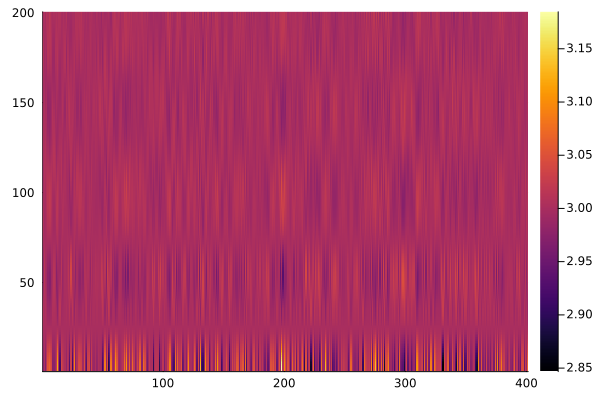

In [26]:
heatmap(V[1:200,:])

In [48]:
## Waves ## - Inhomogeneous external stimulation
re = 0.0001;       # excitatory range (m)
ri = 0.001;
#v = 0.16;         # propagation velocity (m/s)
ai = 100.;
ae = 101.;
r = re/ri;
L_ies = L_real/re
du_ies = L_ies/(N)
display(du_ies)
display(L_ies)
muP = muP0*ones(1,N+1)
x1 = Int64(round((0.475)/(du_ies)))+1;
display(x1)
x2 = Int64(round((0.525)/(du_ies)))+1;
display(x2)
for i = x1:x2
    muP[i] = muP[i] + 20;
end
# display(muP)
eta_1 = 1.0
eta_2 = r
N_t = length(t);
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
I = zeros(N_t,(N+1));
phi = zeros(N_t,(N+1));
J = zeros(N_t,(N+1));
V[1,:] = V0.*ones(1,N+1) .+ 0.05 .*randn(1,N+1);
Ntry = 10
for nt = 1:Ntry
    for nx = 1:N+1
        J[nt,nx] = J_function(V,nx,nt,eta_1,eta_2,du_ies,ae,ai);
    end
    V[nt+1,:] = V[nt,:] .+ dt.*phi[nt,:]
    phi[nt+1,:] = phi[nt,:] .+ dt.*(-2 .*phi[nt,:] .- V[nt,:] .+ J[nt,:] .+ muP')
end

1.25

500.0

1

1

In [49]:
display(V[1:Ntry,:])
display(J[1:Ntry,:])

10×401 Matrix{Float64}:
 3.06046  3.05158  3.07163  3.028    …  2.92283  2.98017  3.02176  3.03179
 3.06046  3.05158  3.07163  3.028       2.92283  2.98017  3.02176  3.03179
 3.11288  3.05365  3.0745   3.02913     2.91975  2.97938  3.02264  3.03307
 3.21248  3.05757  3.07994  3.03127     2.91391  2.97789  3.0243   3.03549
 3.35663  3.06326  3.08782  3.03436     2.90545  2.97572  3.02671  3.039
 3.54474  3.07068  3.09811  3.0384   …  2.89441  2.9729   3.02985  3.04358
 3.77781  3.07989  3.11088  3.04342     2.88071  2.96939  3.03376  3.04927
 4.05763  3.09101  3.12629  3.04947     2.86418  2.96515  3.03847  3.05614
 4.38598  3.10421  3.14458  3.05666     2.84455  2.96012  3.04406  3.0643
 4.76365  3.11972  3.16608  3.06511     2.8215   2.95421  3.05064  3.07389

10×401 Matrix{Float64}:
  1.5288   1.37824  1.71793  0.978079  …   0.165326   0.872034  1.04238
  1.5288   1.37824  1.71793  0.978079      0.165326   0.872034  1.04238
  2.41402  1.41329  1.76642  0.997189      0.151953   0.88691   1.06405
  4.06911  1.47985  1.85851  1.03349       0.126546   0.915174  1.10523
  6.359    1.57614  1.99165  1.08603       0.0897754  0.956078  1.16482
  9.06977  1.70179  2.16526  1.15463   …   0.0417656  1.00948   1.24261
 11.8816   1.85759  2.38033  1.23975      -0.0178239  1.07577   1.33914
 14.4227   2.04539  2.6392   1.34246      -0.0897456  1.15577   1.4556
 16.4031   2.26797  2.94541  1.46437      -0.175134   1.25074   1.5938
 17.7292   2.52894  3.30352  1.6076       -0.275497   1.36235   1.75612

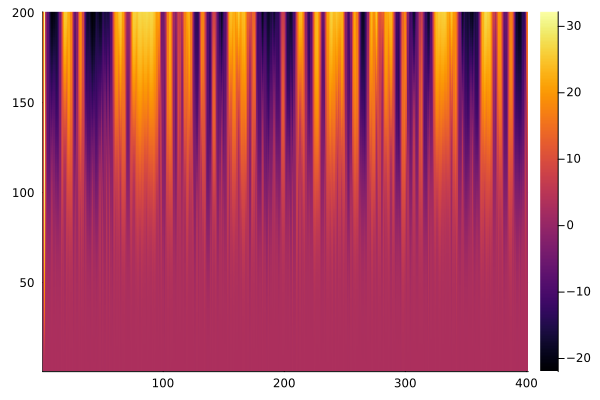

In [37]:
heatmap(V[1:200,:])

In [15]:
## Homogeneous external stimuli
muP0 = 2.5;       # external stimulus (constant)
r = 2.8;          # ratio
ri = re/r;        # inhibitory range (m)
ai = 40.;         # excitatory strenght
ae = 41.;         # inhibitory strenght

In [16]:
## Inhimogeneous external stimulation
muP0 = 2.5;
function muP(x,t)
    return
end
ri = 0.0001;
re = 0.001;
r = re/ri;
ai = 100.;
ae = 101.;

LoadError: cannot define function muP; it already has a value

In [16]:
A = [1 2 3; 4 5 6; 7 8 9]
display(sum(A,dims=1))


1×3 Matrix{Int64}:
 12  15  18